In [1]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sn
import matplotlib.pyplot as plt

In [3]:
meta_df=pd.read_csv(r'C:\Users\HazemHaroun\hazem\Hacking_the_human_body_competition\data\raw_dataset\competition_data\meta_file\train.csv')

In [4]:
meta_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


In [5]:
import os
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T
img_dir=r'C:\Users\HazemHaroun\hazem\Hacking_the_human_body_competition\data\raw_dataset\competition_data\img'
def vis_cell_and_mask(index,meta_df):
    row=meta_df.iloc[index]
    # print(row)
    donar_id=row['id']
    # print(donar_id)
    img_path=os.path.join(img_dir,f"{donar_id}.png")
    # print(img_path)
    plt.figure(figsize=(15, 15))
    plt.imshow(cv2.imread(img_path))
    plt.imshow(rle2mask(row['rle'],shape=(row['img_width'],row['img_height'])),cmap='coolwarm',alpha=0.5)
    plt.axis("off")
    plt.show()
    return 

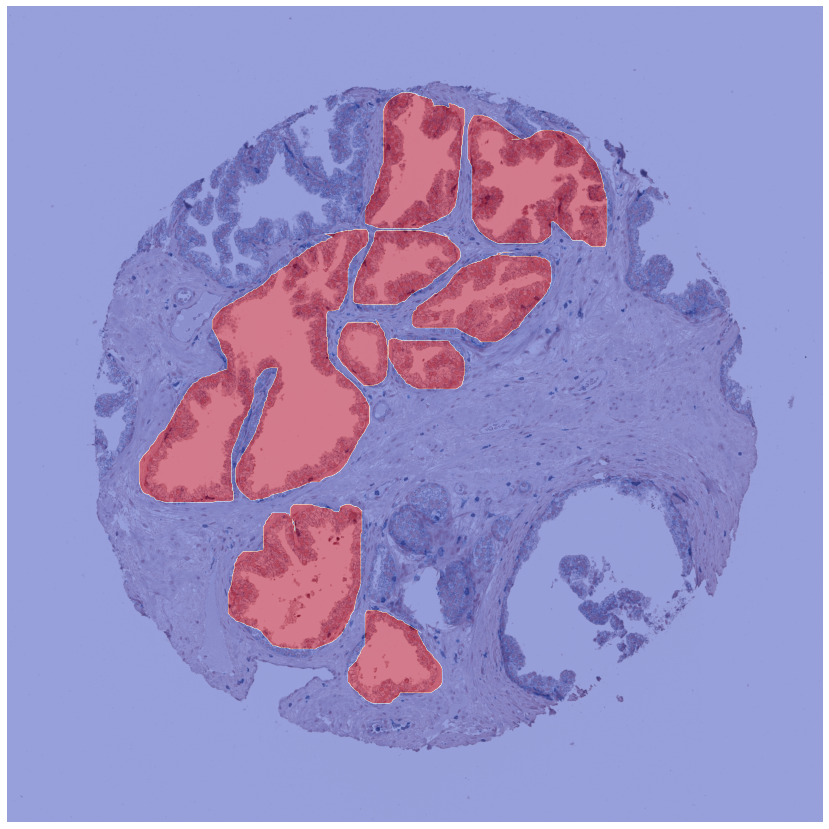

In [6]:
vis_cell_and_mask(0,meta_df)

In [16]:
def get_mask_and_meta_data(index:int,meta_df:pd.DataFrame):
    instance_row=meta_df.iloc[index]
    # print(instance_row)
    rle=instance_row['rle']
    img_width,img_height=int(instance_row['img_width']),int(instance_row['img_height'])
    mask=rle2mask(mask_rle=rle,shape=(img_width,img_height))
    meta_data=instance_row.drop(index=['rle'])
    return mask,meta_data
def vis_img(img):
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

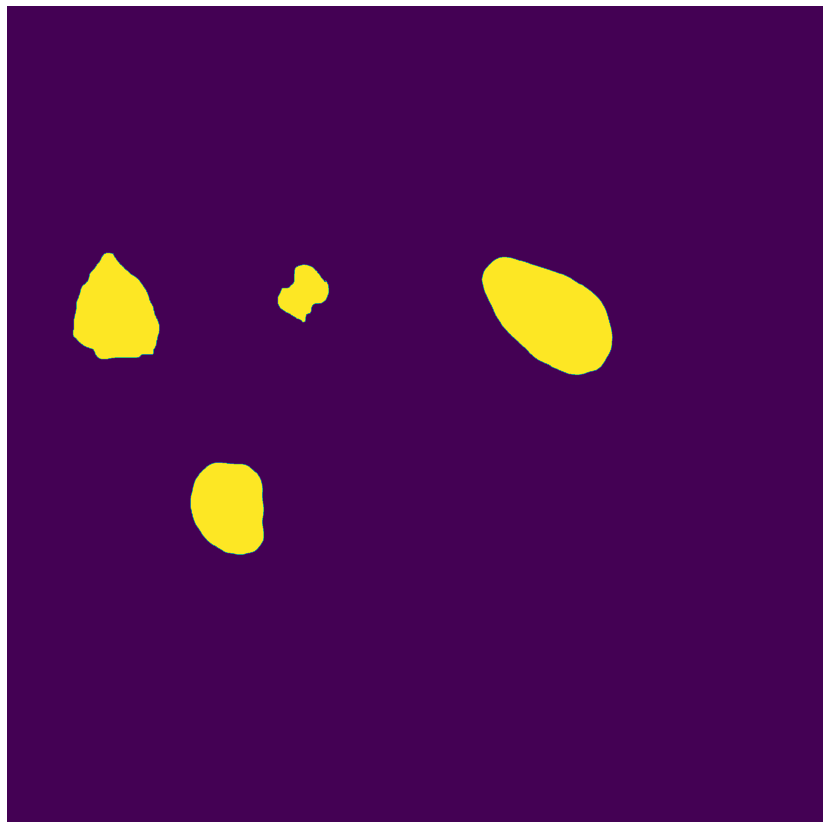

{'id': 10611,
 'organ': 'kidney',
 'data_source': 'HPA',
 'img_height': 3000,
 'img_width': 3000,
 'pixel_size': 0.4,
 'tissue_thickness': 4,
 'age': 68.0,
 'sex': 'Female'}

In [20]:
mask,meta_data=get_mask_and_meta_data(5,meta_df)
vis_img(mask)
meta_data.to_dict()

In [24]:
from tqdm import tqdm
dst_dataset_location=r'C:\Users\HazemHaroun\hazem\Hacking_the_human_body_competition\data\raw_dataset\competition_data'
def create_dataset_from_meta_df(df:pd.DataFrame,dst_dataset_location):
    print(meta_df)
    dst_labels_dir=os.path.join(dst_dataset_location,'lbl')
    dst_meta_dir=os.path.join(dst_dataset_location,'meta')
    if(not os.path.exists(dst_labels_dir)):
        os.makedirs(dst_labels_dir)
    if(not os.path.exists(dst_meta_dir)):
        os.makedirs(dst_meta_dir)

    for i in tqdm(range(len(df)),total=len(df)):
        # print(i)
        inst_mask,inst_meta_data=get_mask_and_meta_data(i,df)
        # print(meta_data)
        inst_id=inst_meta_data['id']
        cv2.imwrite(os.path.join(dst_labels_dir,f'{inst_id}.png'),inst_mask*255)
        inst_meta_data.to_json(os.path.join(dst_meta_dir,f'{inst_id}.json'))
create_dataset_from_meta_df(df=meta_df,dst_dataset_location=dst_dataset_location)

        id           organ data_source  img_height  img_width  pixel_size  \
0    10044        prostate         HPA        3000       3000         0.4   
1    10274        prostate         HPA        3000       3000         0.4   
2    10392          spleen         HPA        3000       3000         0.4   
3    10488            lung         HPA        3000       3000         0.4   
4    10610          spleen         HPA        3000       3000         0.4   
..     ...             ...         ...         ...        ...         ...   
346   9517          kidney         HPA        3000       3000         0.4   
347   9769          kidney         HPA        3070       3070         0.4   
348   9777  largeintestine         HPA        3000       3000         0.4   
349   9791          kidney         HPA        3000       3000         0.4   
350   9904  largeintestine         HPA        3000       3000         0.4   

     tissue_thickness                                                rle  \

100%|██████████| 351/351 [00:13<00:00, 25.41it/s]


In [25]:
import torch
from albumentations.pytorch import ToTensorV2
from albumentations import Compose,Resize,ImageOnlyTransform
class Normalization(ImageOnlyTransform):
    """
    this class normalize the input image by dividing image values by 255

    """
    def __init__(self, always_apply: bool = True, p: float = 1):
        super().__init__(always_apply, p)
    
    def apply(self, img, **params) :
        return img/255.0
transform_pipeline=Compose([
    Resize(height=224,width=224),
    Normalization(),
    ToTensorV2()
])


c:\Users\HazemHaroun\anaconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
img=cv2.imread(r'C:\Users\HazemHaroun\hazem\Hacking_the_human_body_competition\data\raw_dataset\competition_data\img\62.png')
mask=cv2.imread(r'C:\Users\HazemHaroun\hazem\Hacking_the_human_body_competition\data\raw_dataset\competition_data\lbl\62.png',cv2.IMREAD_GRAYSCALE)/255
print(mask.shape,img.shape)

(3000, 3000) (3000, 3000, 3)


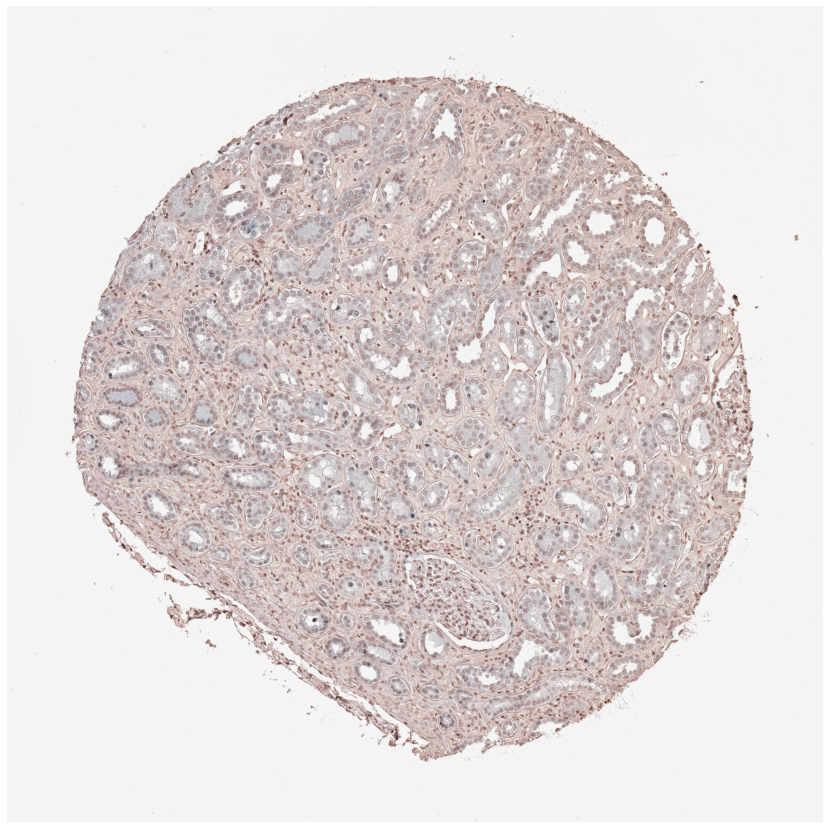

In [28]:
vis_img(img)

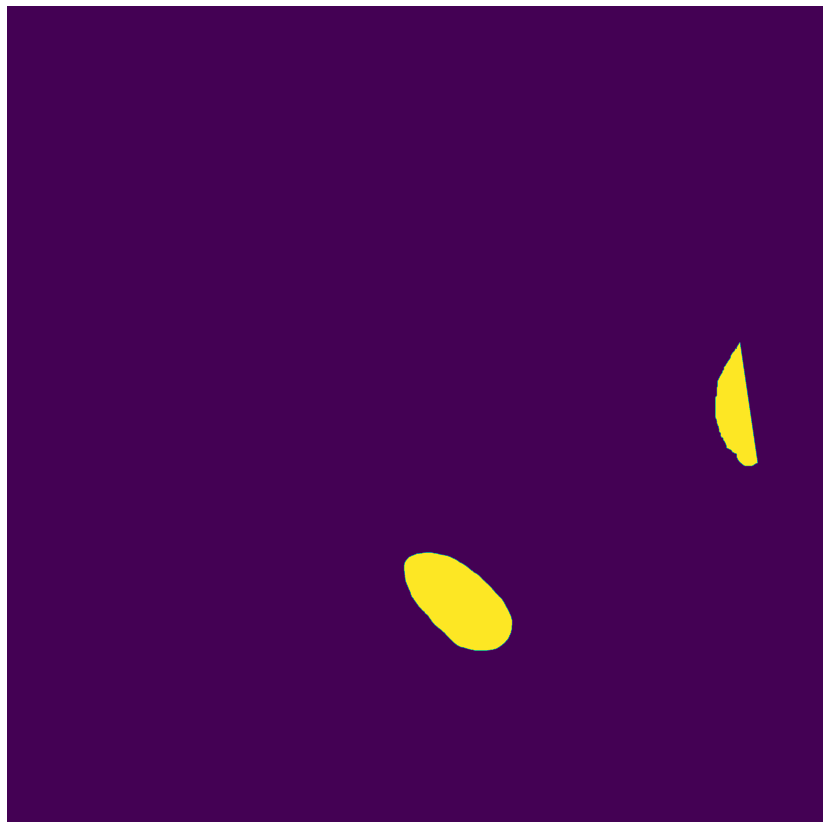

In [29]:
vis_img(mask)

In [30]:
trans_out=transform_pipeline(image=img,mask=mask)
t_img,t_mask=trans_out['image'],trans_out['mask']
print(t_img)
print(t_mask)


tensor([[[0.9569, 0.9569, 0.9608,  ..., 0.9569, 0.9569, 0.9529],
         [0.9529, 0.9529, 0.9529,  ..., 0.9569, 0.9569, 0.9608],
         [0.9569, 0.9569, 0.9608,  ..., 0.9608, 0.9569, 0.9529],
         ...,
         [0.9608, 0.9608, 0.9608,  ..., 0.9412, 0.9608, 0.9608],
         [0.9608, 0.9529, 0.9569,  ..., 0.9608, 0.9608, 0.9608],
         [0.9569, 0.9608, 0.9608,  ..., 0.9490, 0.9569, 0.9569]],

        [[0.9569, 0.9569, 0.9608,  ..., 0.9569, 0.9608, 0.9569],
         [0.9569, 0.9529, 0.9608,  ..., 0.9569, 0.9608, 0.9608],
         [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9569, 0.9490],
         ...,
         [0.9569, 0.9608, 0.9608,  ..., 0.9412, 0.9569, 0.9608],
         [0.9569, 0.9569, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
         [0.9569, 0.9608, 0.9608,  ..., 0.9608, 0.9569, 0.9608]],

        [[0.9569, 0.9569, 0.9569,  ..., 0.9608, 0.9608, 0.9569],
         [0.9569, 0.9569, 0.9608,  ..., 0.9569, 0.9569, 0.9529],
         [0.9608, 0.9608, 0.9490,  ..., 0.9608, 0.9569, 0.

In [31]:
from sklearn.model_selection import train_test_split
train_val_ratio=0.9
train_split_df,val_split_df=train_test_split(meta_df,train_size=train_val_ratio,stratify=meta_df['organ'],random_state=0)

In [32]:
train_dir=r'C:\Users\HazemHaroun\hazem\Hacking_the_human_body_competition\data\splitted_dataset\competition_data_splitted\train'
val_dir=r'C:\Users\HazemHaroun\hazem\Hacking_the_human_body_competition\data\splitted_dataset\competition_data_splitted\val'
create_dataset_from_meta_df(train_split_df,train_dir)
create_dataset_from_meta_df(val_split_df,val_dir)

        id           organ data_source  img_height  img_width  pixel_size  \
0    10044        prostate         HPA        3000       3000         0.4   
1    10274        prostate         HPA        3000       3000         0.4   
2    10392          spleen         HPA        3000       3000         0.4   
3    10488            lung         HPA        3000       3000         0.4   
4    10610          spleen         HPA        3000       3000         0.4   
..     ...             ...         ...         ...        ...         ...   
346   9517          kidney         HPA        3000       3000         0.4   
347   9769          kidney         HPA        3070       3070         0.4   
348   9777  largeintestine         HPA        3000       3000         0.4   
349   9791          kidney         HPA        3000       3000         0.4   
350   9904  largeintestine         HPA        3000       3000         0.4   

     tissue_thickness                                                rle  \

100%|██████████| 315/315 [00:12<00:00, 25.37it/s]


        id           organ data_source  img_height  img_width  pixel_size  \
0    10044        prostate         HPA        3000       3000         0.4   
1    10274        prostate         HPA        3000       3000         0.4   
2    10392          spleen         HPA        3000       3000         0.4   
3    10488            lung         HPA        3000       3000         0.4   
4    10610          spleen         HPA        3000       3000         0.4   
..     ...             ...         ...         ...        ...         ...   
346   9517          kidney         HPA        3000       3000         0.4   
347   9769          kidney         HPA        3070       3070         0.4   
348   9777  largeintestine         HPA        3000       3000         0.4   
349   9791          kidney         HPA        3000       3000         0.4   
350   9904  largeintestine         HPA        3000       3000         0.4   

     tissue_thickness                                                rle  \

100%|██████████| 36/36 [00:01<00:00, 24.90it/s]


In [48]:
def copy_img_split(img_dir,split_dir):
    import shutil
    img_split_dir=os.path.join(split_dir,'img')
    if(not os.path.exists(img_split_dir)):
        os.makedirs(img_split_dir)
    img_filenames=os.listdir(img_dir)
    label_split_dir=os.path.join(split_dir,'lbl')
    for filename in tqdm(os.listdir(label_split_dir),total=len(os.listdir(label_split_dir))):
        if(filename in img_filenames):
            shutil.copy(os.path.join(img_dir,filename),os.path.join(img_split_dir,filename))
copy_img_split(r'C:\Users\HazemHaroun\hazem\Hacking_the_human_body_competition\data\raw_dataset\competition_data\img',
r'C:\Users\HazemHaroun\hazem\Hacking_the_human_body_competition\data\splitted_dataset\competition_data_splitted\train')

copy_img_split(r'C:\Users\HazemHaroun\hazem\Hacking_the_human_body_competition\data\raw_dataset\competition_data\img',
r'C:\Users\HazemHaroun\hazem\Hacking_the_human_body_competition\data\splitted_dataset\competition_data_splitted\val')

100%|██████████| 36/36 [00:00<00:00, 77.38it/s]


In [50]:
print(meta_df['organ'].value_counts())
print(train_split_df['organ'].value_counts())
print(val_split_df['organ'].value_counts())

kidney            99
prostate          93
largeintestine    58
spleen            53
lung              48
Name: organ, dtype: int64
kidney            89
prostate          83
largeintestine    52
spleen            48
lung              43
Name: organ, dtype: int64
prostate          10
kidney            10
largeintestine     6
spleen             5
lung               5
Name: organ, dtype: int64
